In [78]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm
import os

analyze_traj_SAC_AB_T200.0_F0.2_Ta100.0_Esoft4.0_R010_Na500_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_AB_T200.0_F0.2_Ta100.0_Esoft4.0_R010_Na500_blocksize100_kb10.0_dt0.001_kr30.0_rep2_HiC.npy
analyze_traj_SAC_AB_T200.0_F0.2_Ta100.0_Esoft4.0_R010_Na500_blocksize100_kb10.0_dt0.001_kr30.0_rep3_HiC.npy
3


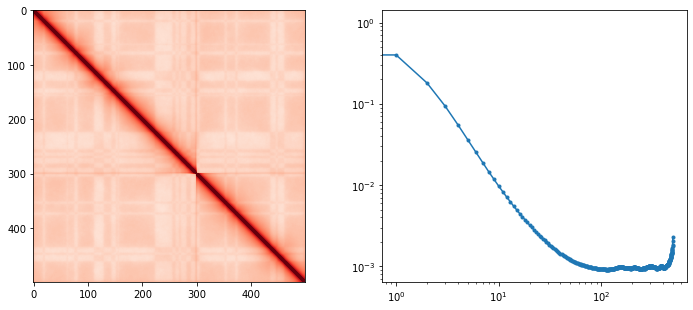

In [104]:
fig,[ax1,ax2]=plt.subplots(1,2, figsize=(12,5))

Ta=100.
F=0.2
fpath='../../data/SAC/hic/'

hic=np.zeros(shape=(500,500))
ii=0
for fname in os.listdir(fpath):
    # print(fname)
    if 'Ta{:.1f}'.format(Ta) in fname and 'F{:.1f}'.format(F) in fname:
        print(fname)
        hic+=np.load(fpath+fname)
        ii+=1
hic=hic/ii

print(ii)
dist=[]
for j in range(1,np.shape(hic)[0]):
    dist.append((np.mean(np.diag(hic,k=j))))

maxD=np.max(dist)
dist=np.array(dist)/maxD
# print(dist)

ax1.imshow(hic, cmap='Reds',norm=LogNorm(vmin=2e-4, vmax=0.1))

ax2.loglog(dist,'.-')


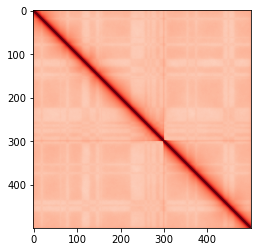